**Projeto Final - Isabela de Souza Silva**

> **Etapa 1**: Leitura do dataset



In [3]:
# Leitura do dataset e importação das bibliotecas necessárias para utilização do Machine Learning

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import  matplotlib.pyplot as plt
import seaborn as sns

In [4]:

db = pd.read_csv('/content/vendas_ecommerce.csv')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Leitura dos 5 primeiras linhas
db.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [6]:
# Análise da tipagem
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    12500 non-null  object 
 1   StockCode    12500 non-null  object 
 2   Description  12455 non-null  object 
 3   Quantity     12500 non-null  int64  
 4   InvoiceDate  12500 non-null  object 
 5   UnitPrice    12500 non-null  float64
 6   CustomerID   8995 non-null   float64
 7   Country      12500 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 781.4+ KB


In [9]:
# Aproveitei para ver se havia algum dado outlier e linhas vazias.
db.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,12500.000000,12500,12500.000000,8995.000000
mean,7.480560,2010-12-03 21:09:34.363200,3.970551,15598.634686
min,-9360.000000,2010-12-01 08:26:00,0.000000,12395.000000
25%,1.000000,2010-12-02 08:32:00,1.250000,14344.000000
50%,2.000000,2010-12-03 11:36:00,2.510000,15646.000000
75%,6.000000,2010-12-05 14:19:00,4.210000,17211.000000
max,2880.000000,2010-12-06 13:13:00,940.870000,18239.000000
std,93.741676,NaN,17.227713,1745.712049


In [7]:
# 1º Alteração: Transformei o tipo de data object para Date da coluna "InvoiceDate"

db['InvoiceDate'] = pd.to_datetime(db['InvoiceDate'])


<ipython-input-7-1849a18606c7>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  db['InvoiceDate'] = pd.to_datetime(db['InvoiceDate'])


In [8]:
# Verifiquei a mudaça na tipagem. Deu certo! :)
db['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [12]:
#2ª Alteração: Criando coluna de valor_total ("Amount")
# Tive essa ideia para definir a variável de Target no Modelo de Predição.
db['Sales_Amount'] = db['Quantity'] * db['UnitPrice']

In [ ]:
# 3ª Alteração
# vou substituir as células vazias de clientes para o cliente que mais comprou para não ter espaços vazios
# percebi que o cliente com ID   17850.0 comprou mais vezes, mas não significa que é o maior cliente, vamos dependenr da coluna
# faturamento para entender de fato quem é o maior cliente


In [13]:
#verificando a soma por cliente

valor_cliente = db.groupby('CustomerID')['Sales_Amount'].sum().reset_index()

# Encontrando o maior valor vendido

maior_valor = valor_cliente.idxmax()
maior_valor

# Encontrando o cliente com maior valor faturado

maior_cliente = valor_cliente.loc[maior_valor,'CustomerID']

maior_cliente
# Identifique que o maior cliente tem o ID "18239" e comprou o total de USD 15.061,00

371    18239.0
156    15061.0
Name: CustomerID, dtype: float64

In [14]:
#vou substituir as linhas vazinhas da coluna "CustomerID" pelo maior cliente

db['CustomerID'] = db['CustomerID'].fillna(maior_cliente)

db['CustomerID'] = db['CustomerID'].fillna(18239.0)

In [63]:
# 4 Alteração: Verifiquei números negativos e nulos na coluna "Quantity"pelo "Describe"
# Dessa maneira, excluí os valores:

db_modificado = db[db['Quantity'] > 0]
db_final = db_modificado[db_modificado['UnitPrice'] > 0]


In [64]:
# 5ª Alteração: Excluir a coluna de data, pois a data é de 03/12/2010 a 06/12/2010, dessa forma, o mês é o mesmo para todas as compras, dessa forma decidi excluir a coluna,
# pois não consigo verificar a sazonalidade em poucos dias.

db_final = db_final.drop(['InvoiceDate'], axis=1)

In [17]:
db_final.info()
# database está limpinho ;)

<class 'pandas.core.frame.DataFrame'>
Index: 12324 entries, 0 to 12499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   InvoiceNo     12324 non-null  object 
 1   StockCode     12324 non-null  object 
 2   Description   12324 non-null  object 
 3   Quantity      12324 non-null  int64  
 4   UnitPrice     12324 non-null  float64
 5   CustomerID    12324 non-null  float64
 6   Country       12324 non-null  object 
 7   Sales_Amount  12324 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 866.5+ KB


> Etapa 2 e 3: **Análise Exploratória e Estatística básica**




In [18]:
# Insight 01 - Vamos analisar a média das vendas, mínimo e máximo

db_final['Sales_Amount'].mean(axis=0)

# Média de USD 17,89: são produtos muito baratos

17.89685654008439

In [19]:
db_final['Sales_Amount'].min(axis=0)

0.14

In [20]:
db_final['Sales_Amount'].max(axis=0)

1627.2

<Axes: xlabel='Sales_Amount', ylabel='Count'>

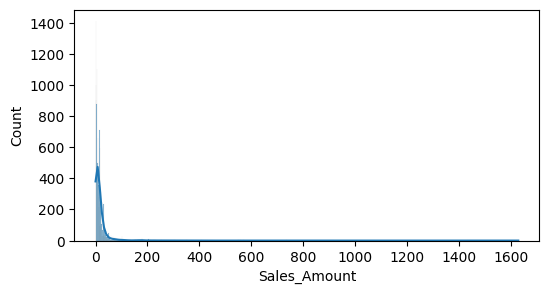

In [21]:
plt.figure(figsize=(6, 3))
sns.histplot(data=db_final, x='Sales_Amount', kde=True)

#Insight 02
# Através do gráfico, percebe-se que a maioria das vendas realizada variaram USD 0 a USD 100.
# Também conseguimos ver os valores máximos e mínimos

In [22]:
#Insight 03
# Importante saber o produto mais vendido para adquirir mais produtos futuramente.
quantidade_por_produto = db_final.groupby('Description')['Quantity'].sum().reset_index()

quantidade_por_produto = quantidade_por_produto.sort_values(by='Quantity', ascending=False)
produto_mais_vendido = quantidade_por_produto.iloc[0]
produto_mais_vendido

Description    WORLD WAR 2 GLIDERS ASSTD DESIGNS
Quantity                                    3417
Name: 2090, dtype: object

Text(0.5, 1.0, 'Valor de Vendas por País')

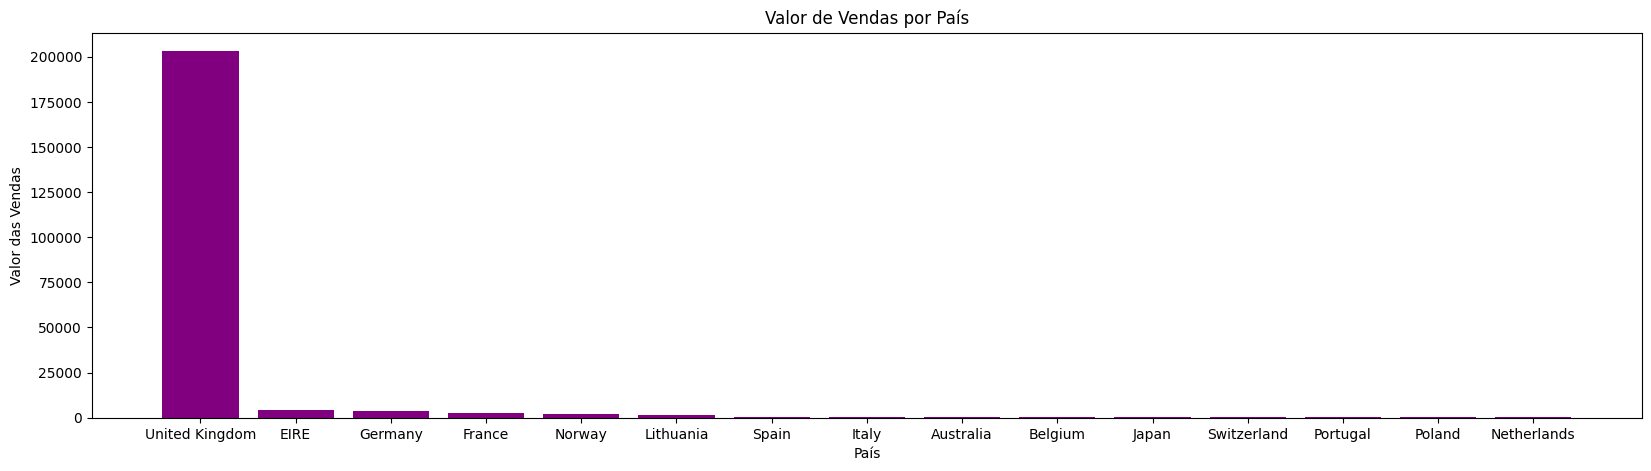

In [23]:
# Insight nº 04 - Saber a quantidade de produto por país é importante para definir a estatégia de marketing e de exportação

# Realizei o agrupamento por país e total de compra
vendas_por_pais = db_final.groupby('Country')['Sales_Amount'].sum().reset_index()

# Ordenei os valores de acordo com o valor da venda para gerar o gráfico correto
vendas_por_pais = vendas_por_pais.sort_values(by='Sales_Amount', ascending=False)

# Criei o gráfico
plt.figure(figsize=(20, 5))
plt.bar(vendas_por_pais['Country'], vendas_por_pais['Sales_Amount'], color='purple')
plt.xlabel('País')
plt.ylabel('Valor das Vendas')
plt.title('Valor de Vendas por País')

Etapa 4: **Modelo de Machine Learning**


In [54]:
# Eu realizei a Definição do target (Valor faturado - "Sales Amount") e features (demais colunas)

X = db_final[['InvoiceNo', 'StockCode','CustomerID','Country','Quantity','Description','UnitPrice']]
y = db_final['Sales_Amount']

In [55]:
# Fiz  a divisão dos tipos de Dados: Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [56]:
# O Pré-processamento foi realizado com a divisão das features entre númericas e categóricas
numeric_features = ['Quantity','UnitPrice']
categorical_features = ['CustomerID', 'InvoiceNo','StockCode','Country','Description']

In [57]:
# Utilizei o preprocessor para padronizar as colunas numéricas e codificar as colunas categóricas

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [58]:
# Na fase de Pipeline de treino, usei o preprocessor definido anteriormente e o modelo de ML escolhido RandomForetRegressor
# Como os preços dos produtos são baixos, defini o n_estimators 800 para ter uma quantidade considerável de árvores de decisão


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=800, random_state=99))
])

In [59]:
# Treinamento do modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Quantity', 'UnitPrice']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CustomerID', 'InvoiceNo',
                                                   'StockCode', 'Country',
                                                   'Description'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=800, random_state=99))])

In [60]:
# Código para Predições utlizando o target
y_pred = model.predict(X_test)


In [61]:
# Para mensurar o resultado do modelo construído, escolhi a métrica MSE, que traz o valor médio do erro apurado.
# Assim, cosseguimos enxergar a diferença entre o valor real e o valor predito.

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 113.491500603547
